# A Cappella Classifier Demo

This notebook loads my audio preprocessing utilities, trains a simple classifier on my custom dataset, and provides helper functions to **classify and visualize new audio clips** as a cappella or non-a cappella.


In [1]:
from google.colab import drive
drive.mount("/content/drive")

# Work in /content
%cd /content

# Clone repo (ok if it already exists; you can skip this cell in that case)
!git clone https://github.com/gamendoza26/acapella-detector.git

# Move into repo and switch to the working branch
%cd /content/acapella-detector
!git switch working-pipeline

import sys, os
sys.path.append(os.path.join(os.getcwd(), "src"))

print("Current directory:", os.getcwd())

Mounted at /content/drive
/content
Cloning into 'acapella-detector'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 104 (delta 48), reused 39 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 109.99 KiB | 5.00 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/acapella-detector
Branch 'working-pipeline' set up to track remote branch 'working-pipeline' from 'origin'.
Switched to a new branch 'working-pipeline'
Current directory: /content/acapella-detector


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from preprocessing.audio import load_and_process_audio

# Path to raw audio on Drive
BASE_RAW = "/content/drive/MyDrive/acapella-detector/data/raw"

CLASS_NAMES = {0: "non_acapella", 1: "acapella"}
print("Base raw data folder:", BASE_RAW)


Base raw data folder: /content/drive/MyDrive/acapella-detector/data/raw


In [3]:
X = []       # list of mel-spectrograms (2D arrays)
y = []       # labels (0 = non_acapella, 1 = acapella)
paths = []   # file paths, just for reference

label_map = {"acapella": 1, "non_acapella": 0}

for folder_name, label in label_map.items():
    folder_path = os.path.join(BASE_RAW, folder_name)
    audio_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".wav", ".mp3", ".m4a", ".flac"))
    ]
    print(f"{folder_name}: found {len(audio_files)} files")

    for fname in sorted(audio_files):
        path = os.path.join(folder_path, fname)
        S_db = load_and_process_audio(path)
        X.append(S_db)
        y.append(label)
        paths.append(path)

y = np.array(y)
print("Total samples:", len(X))
print("Label counts:", {cls: int((y == lab).sum()) for cls, lab in label_map.items()})
print("First spectrogram shape:", X[0].shape if len(X) > 0 else None)


acapella: found 17 files


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

non_acapella: found 17 files


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa

Total samples: 34
Label counts: {'acapella': 17, 'non_acapella': 17}
First spectrogram shape: (128, 509)


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [4]:
def spectrogram_to_feature(S_db):
    """
    Collapse a mel-spectrogram (n_mels, time) into a 1D feature vector
    by averaging over the time axis.
    """
    return S_db.mean(axis=1)

X_feats = np.stack([spectrogram_to_feature(S) for S in X])
print("Feature matrix shape:", X_feats.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (34, 128)
Labels shape: (34,)


In [5]:
# Train/test split
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X_feats, y, paths, test_size=0.3, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Evaluate
train_acc = clf.score(X_train_scaled, y_train)
test_acc = clf.score(X_test_scaled, y_test)
y_pred = clf.predict(X_test_scaled)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy:  {test_acc:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["non_acapella", "acapella"]))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Train size: 23
Test size: 11
Train accuracy: 1.000
Test accuracy:  1.000

Classification report:
              precision    recall  f1-score   support

non_acapella       1.00      1.00      1.00         6
    acapella       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Confusion matrix:
[[6 0]
 [0 5]]


In [6]:
def clip_to_feature(path):
    """
    Load an audio clip, convert to mel-spectrogram, then to a scaled
    feature vector ready for the classifier.
    """
    S_db = load_and_process_audio(path)
    feat = spectrogram_to_feature(S_db)
    feat = feat.reshape(1, -1)
    feat_scaled = scaler.transform(feat)
    return feat_scaled, S_db

def classify_clip(path, show_spectrogram=True):
    """
    Run the trained classifier on one audio file and optionally
    display its mel-spectrogram.
    """
    feat_scaled, S_db = clip_to_feature(path)
    probs = clf.predict_proba(feat_scaled)[0]
    pred = int(np.argmax(probs))
    label = CLASS_NAMES[pred]
    confidence = probs[pred]

    print(f"File: {path}")
    print(f"Predicted label: {label}")
    print(f"Confidence: {confidence:.3f}")

    if show_spectrogram:
        plt.figure(figsize=(8, 3))
        librosa.display.specshow(S_db, y_axis="mel", x_axis=None)
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"Mel spectrogram ({label}, p={confidence:.2f})")
        plt.tight_layout()
        plt.show()

    return label, confidence


Random acapella example:


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


File: /content/drive/MyDrive/acapella-detector/data/raw/acapella/acapella_10.m4a
Predicted label: acapella
Confidence: 0.915


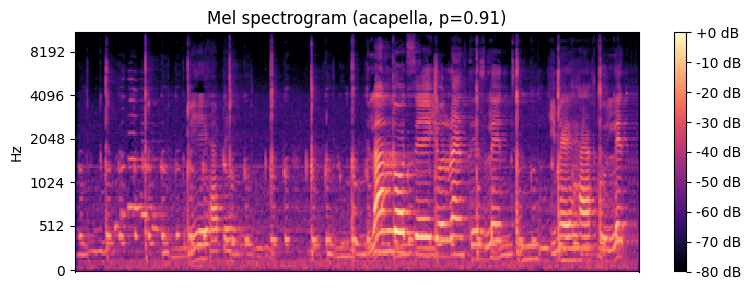


Random non_acapella example:


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


File: /content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_01.m4a
Predicted label: non_acapella
Confidence: 0.934


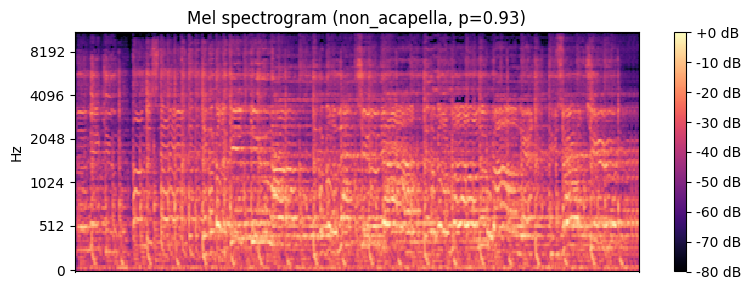

('/content/drive/MyDrive/acapella-detector/data/raw/non_acapella/nonacapella_01.m4a',
 'non_acapella',
 np.float64(0.9335081008700076))

In [7]:
import random

def demo_random_example(target_folder="acapella"):
    """
    Pick a random file from one of the dataset folders and classify it.
    target_folder should be 'acapella' or 'non_acapella'.
    """
    folder_path = os.path.join(BASE_RAW, target_folder)
    files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".wav", ".mp3", ".m4a", ".flac"))
    ]
    if not files:
        print("No files found in", folder_path)
        return

    fname = random.choice(files)
    path = os.path.join(folder_path, fname)
    label, confidence = classify_clip(path, show_spectrogram=True)
    return path, label, confidence

# Example usage:
print("Random acapella example:")
demo_random_example("acapella")

print("\nRandom non_acapella example:")
demo_random_example("non_acapella")


Upload an audio file (.wav, .mp3, .m4a, .flac) to classify it:


Saving acapella_05.m4a to acapella_05.m4a

--- Classifying uploaded file ---


/content/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


File: acapella_05.m4a
Predicted label: acapella
Confidence: 0.988


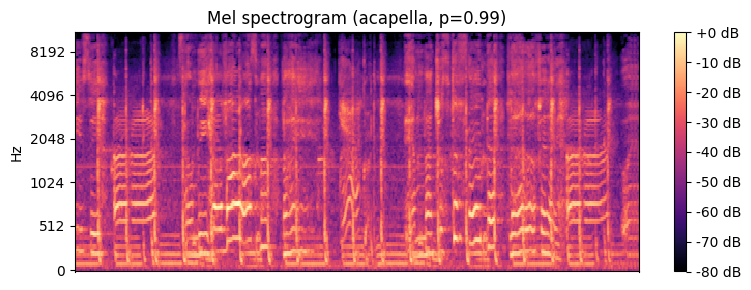

In [9]:
from google.colab import files

print("Upload an audio file (.wav, .mp3, .m4a, .flac) to classify it:")

uploaded = files.upload()

for fname in uploaded.keys():
    path = fname  # Colab saves it in the current working directory
    print("\n--- Classifying uploaded file ---")
    classify_clip(path, show_spectrogram=True)
